# Malaria Cell image classification Recall 0.96 %

Name : Kresna Andika Aprianto <br>
Email : kresnaandika36@gmail.com<br>
Github : github.com/kresnandika<br>
uname dicoding: fiellin

===== This code is all my own with some references, feel free to use it 🍺 =====



---

Malaria is caused by Plasmodium parasites. The parasites are spread to people through the bites of infected female Anopheles mosquitoes, called "malaria vectors." There are 5 parasite species that cause malaria in humans, and 2 of these species – P. falciparum and P. vivax – pose the greatest threat.

source : https://www.who.int/news-room/fact-sheets/detail/malaria

In this kernel, I have shown the stepwise process of creating Convolution Neural Network Model using keras library for classifying images of Normal and Malaria parasite infected human blood sample.

## Step 1: Importing Essential Libraries

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import zipfile
import random
import os
import matplotlib.pyplot as plt
import cv2
import scipy
import skimage
import tensorflow
from tensorflow import keras
from PIL import Image
from sklearn.metrics import roc_curve,auc,classification_report
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout  
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from random import shuffle
from tqdm import tqdm  
from skimage.transform import resize
from google.colab import drive

## Step 2: Loading Data

In [4]:
drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/datasets/malaria_cell_images_dataset.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
# setting path of directory
PARA_DIR = "/tmp/cell_images/Parasitized/"
NORM_DIR =  "/tmp/cell_images/Uninfected/"

# storing all the files from directories PARA_DIR and NORM_DIR to Pimages and Nimages for accessing images directly
Pimages = os.listdir(PARA_DIR)
Nimages = os.listdir(NORM_DIR)

## Step 3: EDA -> Checking sample images
In this step we will check the actual sample images of both infected and normal blood sample

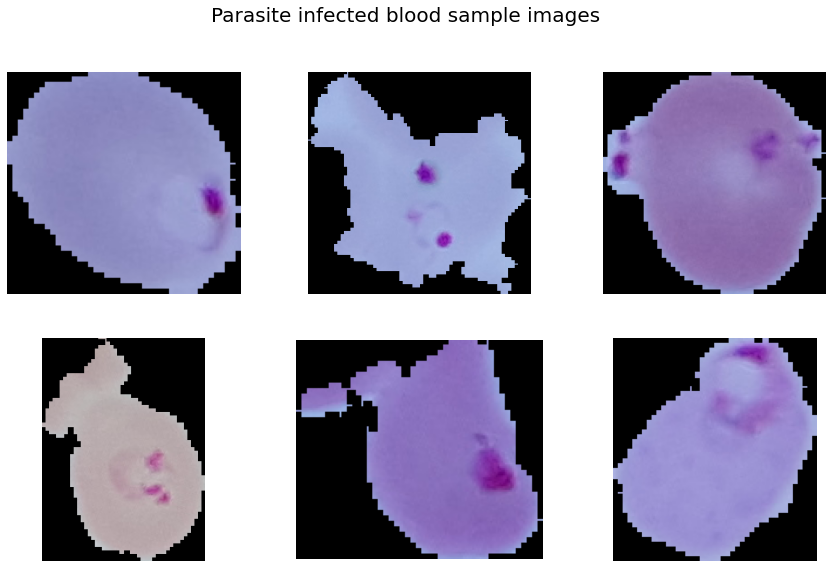

In [6]:
sample_parasite = random.sample(Pimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread('/tmp/cell_images/Parasitized/'+sample_parasite[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Parasite infected blood sample images',fontsize=20)
plt.show()

**Observation:**

As we can see from above images that in infected sample there is small dot in almost every image which may be the critical mark while recognizing the imfected image. the model has to learn this pattern during training stage.

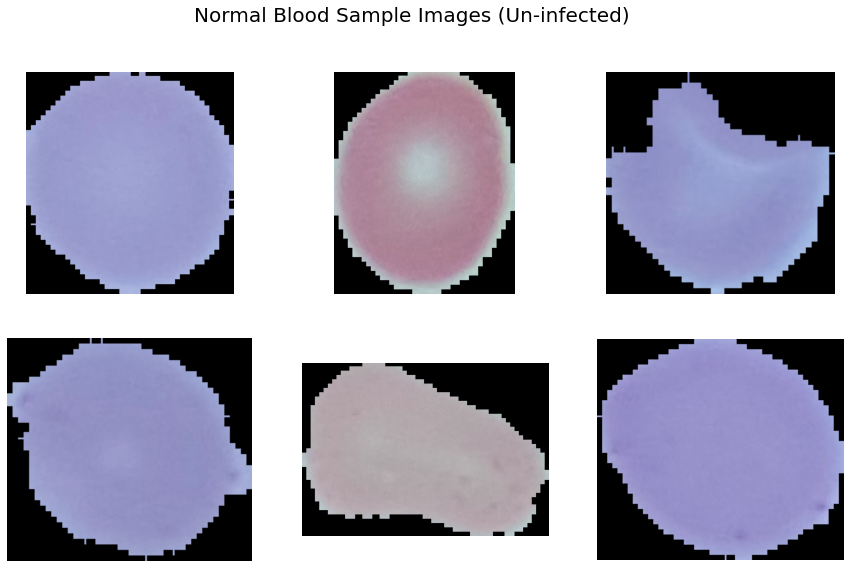

In [7]:
sample_normal = random.sample(Nimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread('/tmp/cell_images/Uninfected/'+sample_normal[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Normal Blood Sample Images (Un-infected)', fontsize=20)
plt.show()

**Observation:**

As we can see normal images are clear with no mark to show.

## Step 4: Data Preprocessing (Labeling & Resizing of images)

In [8]:
data=[]
labels=[]
Parasitized=os.listdir("/tmp/cell_images/Parasitized/")
for a in Parasitized:
    try:
        image=cv2.imread("/tmp/cell_images/Parasitized/"+a)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((50, 50))
        data.append(np.array(size_image))
        labels.append(0)
    except AttributeError:
        print("")

Uninfected=os.listdir("/tmp/cell_images/Uninfected/")
for b in Uninfected:
    try:
        image=cv2.imread("/tmp/cell_images/Uninfected/"+b)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((50, 50))
        data.append(np.array(size_image))
        labels.append(1)
    except AttributeError:
        print("")

print(f"Found {len(data)} images")



Found 27558 images


In [9]:
# segregating data and labels
Cells=np.array(data)
labels=np.array(labels)

np.save("Cells",Cells)
np.save("labels",labels)

In [10]:
# loading data of cell images and labels of images
Cells=np.load("Cells.npy")
labels=np.load("labels.npy")

In [11]:
s=np.arange(Cells.shape[0])
np.random.shuffle(s)
Cells=Cells[s]
labels=labels[s]

num_classes=len(np.unique(labels))
len_data=len(Cells)

## Step 5: Train- Test Split

In [12]:
# splitting cells images into 80:20 ratio i.e., 80% for training and 20% for testing purpose
(x_train,x_test)=Cells[(int)(0.2*len_data):],Cells[:(int)(0.2*len_data)]

(y_train,y_test)=labels[(int)(0.2*len_data):],labels[:(int)(0.2*len_data)]


## Step 6: Normalizing Data

In [13]:
x_train = x_train.astype('float32')/255 # As we are working on image data we are normalizing data by divinding 255.
x_test = x_test.astype('float32')/255
train_len=len(x_train)
test_len=len(x_test)

## Step 7: Label Encoding

In [14]:
#Doing One hot encoding as classifier has multiple classes
y_train=keras.utils.to_categorical(y_train,num_classes)
y_test=keras.utils.to_categorical(y_test,num_classes)

Step 8: Model Building: CNN

In [15]:
# Set random seed
np.random.seed(0)

#creating sequential model
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu",input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))


model.add(Flatten())

model.add(Dense(512,activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(2,activation="softmax"))#2 represent output layer neurons 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 32)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 32)        4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        4

## Step 9: Compiling the model

In [16]:
# compile the model with loss as categorical_crossentropy and using adam optimizer you can test result by trying RMSProp as well as Momentum
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Step 10: Setting Callbacks

In [17]:
class myCallback(tensorflow.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>=0.99):
      print("--> Callback: Reached 99% accuracy. That's perfect, Cheers! <--")
      self.model.stop_training = True

callbacks = myCallback()

## Step 11: Model Fitting

In [23]:
#Fit the model with min batch size as 32 can tune batch size to some factor of 2^power ] 
h=model.fit(x_train,y_train,batch_size=32,callbacks=callbacks, validation_data=(x_test,y_test),epochs=100,verbose=1)

Epoch 1/100
689/689 [==============================] - 54s 79ms/step - loss: 0.2106 - accuracy: 0.9299 - val_loss: 0.1801 - val_accuracy: 0.9441
Epoch 2/100
689/689 [==============================] - 55s 79ms/step - loss: 0.1667 - accuracy: 0.9484 - val_loss: 0.1631 - val_accuracy: 0.9494
Epoch 3/100
689/689 [==============================] - 55s 79ms/step - loss: 0.1554 - accuracy: 0.9512 - val_loss: 0.1629 - val_accuracy: 0.9497
Epoch 4/100
689/689 [==============================] - 55s 79ms/step - loss: 0.1480 - accuracy: 0.9551 - val_loss: 0.1758 - val_accuracy: 0.9477
Epoch 5/100
689/689 [==============================] - 55s 80ms/step - loss: 0.1415 - accuracy: 0.9546 - val_loss: 0.1519 - val_accuracy: 0.9510
Epoch 6/100
689/689 [==============================] - 54s 79ms/step - loss: 0.1385 - accuracy: 0.9551 - val_loss: 0.1651 - val_accuracy: 0.9492
Epoch 7/100
689/689 [==============================] - 54s 79ms/step - loss: 0.1368 - accuracy: 0.9553 - val_loss: 0.1520 - val_ac

## Step 12: Plot loss, Accuracy, Classification report and Confusion Matrix

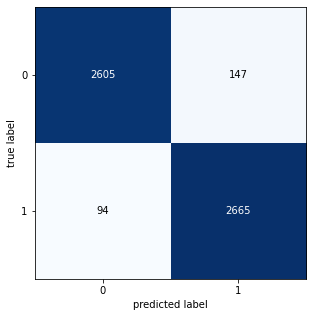

In [26]:
from sklearn.metrics import confusion_matrix
pred = model.predict(x_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

#creating confusion matrix
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
# plotting confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

Plotting History of Model's Accuracy

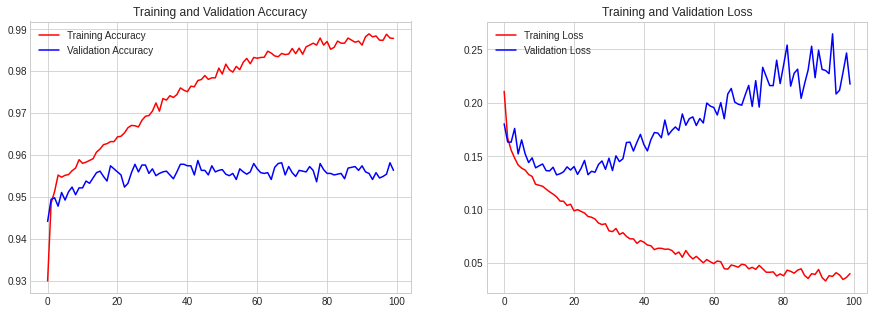

In [41]:
plt.style.use('seaborn-whitegrid')

def plot_acc(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  plt.subplot(1, 2, 1)
  acc_plot, = plt.plot(epochs, acc, 'r')
  val_acc_plot, = plt.plot(epochs, val_acc, 'b')
  plt.title('Training and Validation Accuracy')
  plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])


def plot_loss(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.subplot(1, 2, 2)
  loss_plot, = plt.plot(epochs, loss, 'r')
  val_loss_plot, = plt.plot(epochs, val_loss, 'b')
  plt.title('Training and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])

def plot_history(history):
  plt.figure(figsize=(15,5))
  plot_acc(history)
  plot_loss(history)


plot_history(h)

Printing Classification report

In [29]:
print('{}'.format(classification_report(y_true , pred)))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2752
           1       0.95      0.97      0.96      2759

    accuracy                           0.96      5511
   macro avg       0.96      0.96      0.96      5511
weighted avg       0.96      0.96      0.96      5511



## Step 13: Plotting ROC AUC Curve
In this step we will first compute Are Under Curve (AUC) based on which we plot ROC curve

**Computing Area Under Curve (AUC)**

In [54]:
fpr_keras, tpr_keras, thresholds = roc_curve(y_true.ravel(), pred.ravel())
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

0.9562569934969698

In [31]:
def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=(10,6))
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

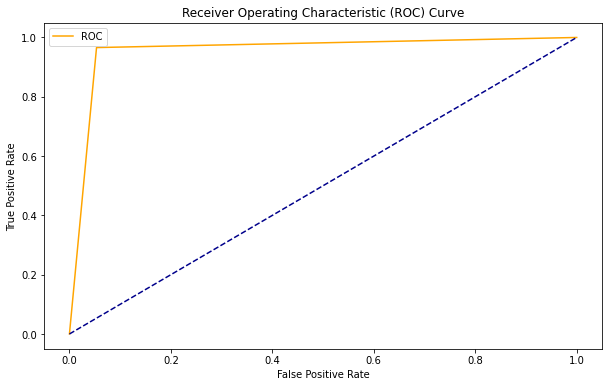

In [32]:
plot_roc_curve(fpr_keras, tpr_keras)

## Step 15: Plotting Sample Prediction (Groundtruth vs Predicted)
In this step we will test our model by plotting 12 random prediction in which ground truth is in brackets and predicted value is outside the bracket if both match then the color will be blue whereas incorrect or misclassified instances will show in orange color.

In [33]:
y_hat = model.predict(x_test)

# define text labels 
malaria_labels = ['Parasitized','Uninfected']

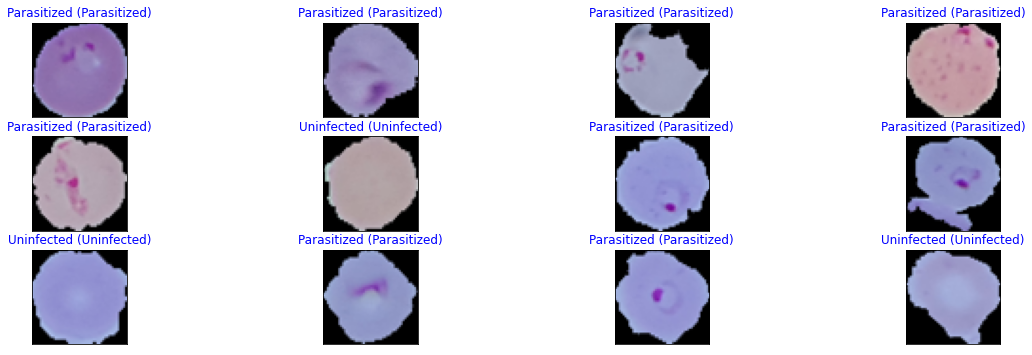

In [34]:
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=12, replace=False)):
    ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(malaria_labels[pred_idx], malaria_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "orange"))

In [92]:
converter = tensorflow.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with tensorflow.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp983xlaqm/assets


INFO:tensorflow:Assets written to: /tmp/tmp983xlaqm/assets


## Conclusion & Future Improvements

*   As we have seen our model is giving approx 97% recall nd auc of around 96.36 which is good overall.
*   Further, we can also do data augmentation to increase the dataset and improve the accuracy
*   The only misclassified instance shown in our random sample plotting has seems to have a small mark but in real its not which our model errorneously understand as a mark and therefore predicted as infected sample.